[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/efurlanm/418/blob/master/pinn-quadrature-burgers.ipynb)

# Using PINN as an interpolator

*Last edited 2023-05-16*

Generally [PINN (Physics-Informed Neural Network)](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) are related to function approximators, but in this work the intention is to use it as if it were an interpolator, and compare the results with the GHQ (Burkardt's Gauss-Hermite Quadrature) which is a form of Gaussian quadrature to approximate integral values. As a toy problem the solution of the 1D Burgers equation will be used.

This work is based on the work of:

- Pierre Jacquier https://github.com/pierremtb/PINNs-TF2.0
- Maziar Raissi https://github.com/maziarraissi/PINNs
- John Burkardt https://people.sc.fsu.edu/~jburkardt/
- and others

In [49]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#repoPath = os.path.join("../..", "")
repoPath = os.path.join("Raissi", "")
utilsPath = os.path.join(repoPath, "Utilities")
appDataPath = os.path.join(repoPath, "appendix", "Data")
sys.path.insert(0, utilsPath)

In [50]:
import tensorflow as tf
from tensorflow import keras
from plotting import newfig, savefig
import scipy.io
import numpy as np
import time
from datetime import datetime
from pyDOE import lhs
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [51]:
from tensorflow.python.client import device_lib

Check the GPU:

In [52]:
with tf.device('/GPU:0'):
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2978534189062550270
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2416967680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5536666716519011628
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [53]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [54]:
! nvidia-smi

Sat Apr 29 21:01:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8    N/A /  N/A |   2595MiB /  3072MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

Class to prepare the data. For example, the collocation points are defined here. Collocation points are integration domain entry points used during neural network training.

In [56]:
def prep_data(path,
              N_u=None,
              N_f=None,
              N_n=None,
              q=None,
              ub=None,
              lb=None,
              noise=0.0,
              idx_t_0=None,
              idx_t_1=None,
              N_0=None,
              N_1=None):

    # Reading external data [t is 100x1, usol is 256x100 (solution),
    #                        x is 256x1]
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data["t"].flatten()[:, None]  # T x 1
    x = data["x"].flatten()[:, None]  # N x 1

    # Keeping the 2D data for the solution data (real() is maybe
    # to make it float by default, in case of zeroes)
    Exact_u = np.real(data["usol"]).T  # T x N

    if (N_n != None and q != None and ub != None and lb != None and
            idx_t_0 != None and idx_t_1 != None):
        dt = t[idx_t_1] - t[idx_t_0]
        idx_x = np.random.choice(Exact_u.shape[1], N_n, replace=False)
        x_0 = x[idx_x, :]
        u_0 = Exact_u[idx_t_0:idx_t_0 + 1, idx_x].T
        u_0 = u_0 + noise * np.std(u_0) * np.random.randn(
            u_0.shape[0], u_0.shape[1])

        # Boudanry data
        x_1 = np.vstack((lb, ub))

        # Test data
        x_star = x
        u_star = Exact_u[idx_t_1, :]

        # IRK = Implicit Runge–Kutta time integrators
        # Load IRK weights
        tmp = np.float32(
            np.loadtxt(os.path.join(utilsPath, "IRK_weights",
                                    "Butcher_IRK%d.txt" % (q)),
                       ndmin=2))
        IRK_weights = np.reshape(tmp[0:q**2 + q], (q + 1, q))
        IRK_times = tmp[q**2 + q:]

        return (x, t, dt, Exact_u, x_0, u_0, x_1, x_star, u_star, IRK_weights,
                IRK_times)

    # Meshing x and t in 2D (256,100)
    X, T = np.meshgrid(x, t)

    # Preparing the inputs x and t (meshed as X, T) for predictions
    # in one single array, as X_star
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

    # Preparing the testing u_star
    u_star = Exact_u.flatten()[:, None]

    idx = np.random.choice(X_star.shape[0], N_u, replace=False)
    X_u_train = X_star[idx, :]
    u_train = u_star[idx, :]

    if N_0 != None and N_1 != None:
        Exact_u = Exact_u.T
        idx_x = np.random.choice(Exact_u.shape[0], N_0, replace=False)
        x_0 = x[idx_x, :]
        u_0 = Exact_u[idx_x, idx_t_0][:, None]
        u_0 = u_0 + noise * np.std(u_0) * np.random.randn(
            u_0.shape[0], u_0.shape[1])

        idx_x = np.random.choice(Exact_u.shape[0], N_1, replace=False)
        x_1 = x[idx_x, :]
        u_1 = Exact_u[idx_x, idx_t_1][:, None]
        u_1 = u_1 + noise * np.std(u_1) * np.random.randn(
            u_1.shape[0], u_1.shape[1])

        dt = np.asscalar(t[idx_t_1] - t[idx_t_0])
        q = int(np.ceil(0.5 * np.log(np.finfo(float).eps) / np.log(dt)))

        # Load IRK weights
        tmp = np.float32(
            np.loadtxt(os.path.join(utilsPath, "IRK_weights",
                                    "Butcher_IRK%d.txt" % (q)),
                       ndmin=2))
        weights = np.reshape(tmp[0:q**2 + q], (q + 1, q))
        IRK_alpha = weights[0:-1, :]
        IRK_beta = weights[-1:, :]
        return (x_0, u_0, x_1, u_1, x, t, dt, q, Exact_u, IRK_alpha, IRK_beta)

    if N_f == None:
        lb = X_star.min(axis=0)
        ub = X_star.max(axis=0)
        return (x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, ub, lb)

    # Domain bounds (lowerbounds upperbounds) [x, t], which are here ([-1.0, 0.0] and [1.0, 1.0])
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
    uu1 = Exact_u[0:1, :].T
    # Getting the lowest boundary conditions (x=-1)
    xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
    uu2 = Exact_u[:, 0:1]
    # Getting the highest boundary conditions (x=1)
    xx3 = np.hstack((X[:, -1:], T[:, -1:]))
    uu3 = Exact_u[:, -1:]
    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2, xx3])
    u_train = np.vstack([uu1, uu2, uu3])

    #  Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 2D domain
    X_f_train = lb + (ub - lb) * lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx, :]
    #  Getting the corresponding u_train
    u_train = u_train[idx, :]

    return (x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f_train,
            ub, lb)

Class to display information about elapsed time, total time, loss, error, and other messages that appear, especially during training, when calling the PhysicsInformedNN class:

In [57]:
class Logger(object):

    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() -
                                      self.start_time).strftime("%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  " +
                  f"elapsed = {self.__get_elapsed()}  " +
                  f"loss = {loss:.4e}  " +
                  f"error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): " +
              f"duration = {self.__get_elapsed()}  " +
              f"error = {self.__get_error_u():.4e}  " + custom)

Custom LBFGS adapted from https://github.com/yaroslavvb/stuff/blob/master/eager_lbfgs/eager_lbfgs.py :

In [58]:
#  LBFGS

# Time tracking functions
global_time_list = []
global_last_time = 0
times = []

def record_time():
    global global_last_time, global_time_list
    new_time = time.perf_counter()
    global_time_list.append(new_time - global_last_time)
    global_last_time = time.perf_counter()

def last_time():
    """Returns last interval records in millis."""
    global global_last_time, global_time_list
    if global_time_list:
        return 1000 * global_time_list[-1]
    else:
        return 0

def dot(a, b):
    """Dot product function since TensorFlow doesn't have one."""
    return tf.reduce_sum(a * b)

def verbose_func(s):
    print(s)

def lbfgs(opfunc, x, config, state, do_verbose, log_fn):
    """port of lbfgs.lua, using TensorFlow eager mode.
    """

    if config.maxIter == 0:
        return

    #global final_loss, times
    global times

    maxIter = config.maxIter
    maxEval = config.maxEval or maxIter * 1.25
    tolFun = config.tolFun or 1e-5
    tolX = config.tolX or 1e-19
    nCorrection = config.nCorrection or 100
    lineSearch = config.lineSearch
    lineSearchOpts = config.lineSearchOptions
    learningRate = config.learningRate or 1
    isverbose = config.verbose or False

    # verbose function
    if isverbose:
        verbose = verbose_func
    else:
        verbose = lambda x: None

    # evaluate initial f(x) and df/dx
    f, g = opfunc(x)

    f_hist = [f]
    currentFuncEval = 1
    state.funcEval = state.funcEval + 1
    p = g.shape[0]

    # check optimality of initial point
    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <= tolFun:
        verbose("optimality condition below tolFun")
        return x, f_hist

    # optimize for a max of maxIter iterations
    nIter = 0
    times = []
    while nIter < maxIter:
        start_time = time.time()

        # keep track of nb of iterations
        nIter = nIter + 1
        state.nIter = state.nIter + 1

        ############################################################
        ## compute gradient descent direction
        ############################################################
        if state.nIter == 1:
            d = -g
            old_dirs = []
            old_stps = []
            Hdiag = 1
        else:
            # do lbfgs update (update memory)
            y = g - g_old
            s = d * t
            ys = dot(y, s)

            if ys > 1e-10:
                # updating memory
                if len(old_dirs) == nCorrection:
                    # shift history by one (limited-memory)
                    del old_dirs[0]
                    del old_stps[0]

                # store new direction/step
                old_dirs.append(s)
                old_stps.append(y)

                # update scale of initial Hessian approximation
                Hdiag = ys / dot(y, y)

            # compute the approximate (L-BFGS) inverse Hessian
            # multiplied by the gradient
            k = len(old_dirs)

            # need to be accessed element-by-element, so don't re-type tensor:
            ro = [0] * nCorrection
            for i in range(k):
                ro[i] = 1 / dot(old_stps[i], old_dirs[i])

            # iteration in L-BFGS loop collapsed to use just one buffer
            # need to be accessed element-by-element, so don't re-type tensor:
            al = [0] * nCorrection

            q = -g
            for i in range(k - 1, -1, -1):
                al[i] = dot(old_dirs[i], q) * ro[i]
                q = q - al[i] * old_stps[i]

            # multiply by initial Hessian
            r = q * Hdiag
            for i in range(k):
                be_i = dot(old_stps[i], r) * ro[i]
                r += (al[i] - be_i) * old_dirs[i]

            # final direction is in r/d (same object)
            d = r

        g_old = g
        f_old = f

        ############################################################
        ## compute step length
        ############################################################
        # directional derivative
        gtd = dot(g, d)

        # check that progress can be made along that direction
        if gtd > -tolX:
            verbose("Can not make progress along direction.")
            break

        # reset initial guess for step size
        if state.nIter == 1:
            tmp1 = tf.abs(g)
            t = min(1, 1 / tf.reduce_sum(tmp1))
        else:
            t = learningRate

        # optional line search: user function
        lsFuncEval = 0
        if lineSearch and isinstance(lineSearch) == types.FunctionType:
            # perform line search, using user function
            f, g, x, t, lsFuncEval = lineSearch(opfunc, x, t, d, f, g, gtd,
                                                lineSearchOpts)
            f_hist.append(f)
        else:
            # no line search, simply move with fixed-step
            x += t * d

            if nIter != maxIter:
                # re-evaluate function only if not in last iteration
                # the reason we do this: in a stochastic setting,
                # no use to re-evaluate that function here
                f, g = opfunc(x)
                lsFuncEval = 1
                f_hist.append(f)

        # update func eval
        currentFuncEval = currentFuncEval + lsFuncEval
        state.funcEval = state.funcEval + lsFuncEval

        ############################################################
        ## check conditions
        ############################################################
        if nIter == maxIter:
            break

        if currentFuncEval >= maxEval:
            # max nb of function evals
            verbose('max nb of function evals')
            break

        tmp1 = tf.abs(g)
        if tf.reduce_sum(tmp1) <= tolFun:
            # check optimality
            verbose('optimality condition below tolFun')
            break

        tmp1 = tf.abs(d * t)
        if tf.reduce_sum(tmp1) <= tolX:
            # step size below tolX
            verbose('step size below tolX')
            break

        if tf.abs(f - f_old) < tolX:
            # function value changing less than tolX
            verbose('function value changing less than tolX' +
                    str(tf.abs(f - f_old)))
            break

        if do_verbose:
            log_fn(nIter, f.numpy(), True)
            #print("Step %3d loss %6.5f msec %6.3f"%(nIter, f.numpy(), last_time()))
            record_time()
            times.append(last_time())

        # if nIter == maxIter - 1:
        #   final_loss = f.numpy()

    # save state
    state.old_dirs = old_dirs
    state.old_stps = old_stps
    state.Hdiag = Hdiag
    state.g_old = g_old
    state.f_old = f_old
    state.t = t
    state.d = d

    return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
    pass

class Struct(dummy):

    def __getattribute__(self, key):
        if key == '__dict__':
            return super(dummy, self).__getattribute__('__dict__')
        return self.__dict__.get(key, 0)

# 1. Continuous Inference

$$u_t + u u_x - \nu u_{xx} = 0$$

With $x \in [-1,1],\quad t \in [0,1],\quad \nu = (0.01/\pi)$.

And $u(0,x) = -\sin(\pi x),\quad u(t,-1) = u(t,1) = 0$

Approximating $u(t,x)$ with a deep NN, we define the PINN:
$$f := u_t + u u_x - \nu u_{xx}.$$

We train the shared parameters between the deep NN and the PINN minimizing the loss:
$$MSE =\frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2 + \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2,$$
with $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ and $\{t_f^i, x_f^i\}_{i=1}^{N_f}$ respectively the initial/boundary data on $u(t,x)$ and collocations points for $f(t,x)$.

### Hyperparameters

In [59]:
# Data size on the solution u
N_u = 100
# Collocation points size, where we’ll check for f = 0
N_f = 10000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
tf_epochs = 100
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,
                                        beta_1=0.99,
                                        epsilon=1e-1)
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_epochs = 1000
nt_config = Struct()
nt_config.learningRate = 0.8
nt_config.maxIter = nt_epochs
nt_config.nCorrection = 50
nt_config.tolFun = 1.0 * np.finfo(float).eps

## PINN class

from Raissi:

In [60]:
class PhysicsInformedNN(object):
    # Initialize the class
    def __init__(self, layers, optimizer, logger, X_f, ub, lb, nu):
        # Descriptive Keras model [2, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(
            tf.keras.layers.Lambda(lambda X: 2.0 * (X - lb) / (ub - lb) - 1.0))
        for width in layers[1:]:
            self.u_model.add(
                tf.keras.layers.Dense(width,
                                      activation=tf.nn.tanh,
                                      kernel_initializer='glorot_normal'))

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))

        self.nu = nu
        self.optimizer = optimizer
        self.logger = logger

        self.dtype = tf.float32

        # Separating the collocation coordinates
        self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)

    # Defining custom loss
    def __loss(self, u, u_pred):
        f_pred = self.f_model()
        return tf.reduce_mean(tf.square(u - u_pred)) + tf.reduce_mean(
            tf.square(f_pred))

    def __grad(self, X, u):
        with tf.GradientTape() as tape:
            loss_value = self.__loss(u, self.u_model(X))
        return loss_value, tape.gradient(loss_value,
                                         self.__wrap_training_variables())

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    # The actual PINN
    def f_model(self):
        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            # Packing together the inputs
            X_f = tf.stack([self.x_f[:, 0], self.t_f[:, 0]], axis=1)

            # Getting the prediction
            u = self.u_model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, self.x_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, self.x_f)
        u_t = tape.gradient(u, self.t_f)

        del tape  # Letting the tape go

        nu = self.get_params(numpy=True)

        f = u_t + u * u_x - nu * u_xx  # Buidling the PINNs

        return f

    def get_params(self, numpy=False):
        return self.nu

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i + 1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    # The training function
    def fit(self, X_u, u, tf_epochs=5000, nt_config=Struct()):
        
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        self.logger.log_train_opt("Adam")

        for epoch in range(tf_epochs):
            # Optimization step
            loss_value, grads = self.__grad(X_u, u)
            self.optimizer.apply_gradients(
                zip(grads, self.__wrap_training_variables()))
            self.logger.log_train_epoch(epoch, loss_value)
            #----------------------------------------

        self.logger.log_train_opt("LBFGS")

        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_value = self.__loss(u, self.u_model(X_u))
            grad = tape.gradient(loss_value, self.u_model.trainable_variables)
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value, grad_flat
            #----------------------------------------

        lbfgs(loss_and_flat_grad, self.get_weights(), nt_config, Struct(), True,
              lambda epoch, loss, is_iter: self.logger.log_train_epoch(
            epoch, loss, "", is_iter))

        self.logger.log_train_end(tf_epochs + nt_config.maxIter)

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.f_model()
        return u_star, f_star

## Training

In [61]:
# Getting the data
path = os.path.join(appDataPath, "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(
    path, N_u, N_f, noise=0.0)

The compute intensive part:

In [62]:
# Creating the model and training
logger = Logger(frequency=10)
pinn = PhysicsInformedNN(layers,
                         tf_optimizer,
                         logger,
                         X_f,
                         ub,
                         lb,
                         nu=0.01 / np.pi)


def error():
    u_pred, _ = pinn.predict(X_star)
    return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)


logger.set_error_fn(error)
pinn.fit(X_u_train, u_train, tf_epochs, nt_config)

TensorFlow version: 2.11.0
Eager execution: True
GPU-accerelated: True

Training started
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 2)                 0         
                                                                 
 dense_18 (Dense)            (None, 20)                60        
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 20)                420       
                                                                 
 dense_22 (Dense)            (None, 20)                420       
                               

## Predict

Getting the model predictions, from the same (x,t) that the predictions were previously gotten from:

In [63]:
%%time
u_pred, f_pred = pinn.predict(X_star)

CPU times: user 64.3 ms, sys: 0 ns, total: 64.3 ms
Wall time: 63.3 ms


In [66]:
u_pred_flat = u_pred.numpy().flatten()

## Plot function

In [64]:
def plot_inf_cont_results(X_star,
                          u_pred,
                          X_u_train,
                          u_train,
                          Exact_u,
                          X,
                          T,
                          x,
                          t,
                          file=None):

    # Interpolating the results on the whole (x,t) domain.
    # griddata(points, values, points at which to interpolate, method)
    U_pred = griddata(X_star, u_pred, (X, T), method="cubic")

    # Creating the figures
    fig, ax = newfig(1.0, 1.1)
    rc('text', usetex=False)
    plt.rcParams['font.serif'] = 'DejaVu Serif'
    ax.axis("off")

    ####### Row 0: u(t,x) ##################
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(U_pred.T,
                  interpolation="nearest",
                  cmap="rainbow",
                  extent=[t.min(), t.max(), x.min(),
                          x.max()],
                  origin="lower",
                  aspect="auto")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)

    ax.plot(X_u_train[:, 1],
            X_u_train[:, 0],
            "kx",
            label="Data (%d points)" % (u_train.shape[0]),
            markersize=4,
            clip_on=False)

    line = np.linspace(x.min(), x.max(), 2)[:, None]
    ax.plot(t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
    ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
    ax.plot(t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

    ax.set_xlabel("t")
    ax.set_ylabel("x")
    ax.legend(frameon=False, loc="best")
    ax.set_title("u(t,x)", fontsize=10)

    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x, Exact_u[25, :], "b-", linewidth=2, label="Exact")
    ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")
    ax.set_xlabel("x")
    ax.set_ylabel("u(t,x)")
    ax.set_title("t = 0.25", fontsize=10)
    ax.axis("square")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x, Exact_u[50, :], "b-", linewidth=2, label="Exact")
    ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")
    ax.set_xlabel("x")
    ax.set_ylabel("u(t,x)")
    ax.axis("square")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title("t = 0.50", fontsize=10)
    ax.legend(loc="upper center",
              bbox_to_anchor=(0.5, -0.35),
              ncol=5,
              frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x, Exact_u[75, :], "b-", linewidth=2, label="Exact")
    ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")
    ax.set_xlabel("x")
    ax.set_ylabel("u(t,x)")
    ax.axis("square")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_title("t = 0.75", fontsize=10)

    plt.show()

## Plot

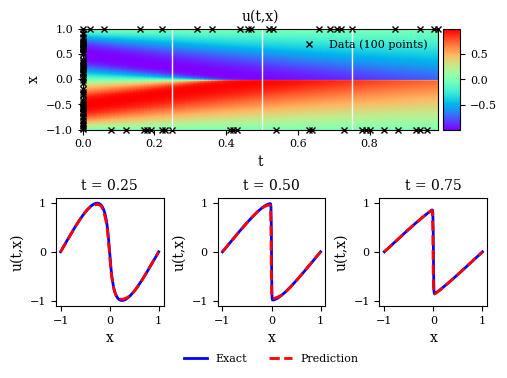

In [67]:
plot_inf_cont_results(X_star, u_pred_flat, X_u_train, u_train, Exact_u, X, T, x,
                      t)

---

Saving the data, loading, and reprinting the graph:

## Save data

In [68]:
np.save('data-X_star.npy', X_star)
np.save('data-u_pred.npy', u_pred)
np.save('data-u_pred_flat.npy', u_pred_flat)
np.save('data-f_pred.npy', f_pred)
np.save('data-X_u_train.npy', X_u_train)
np.save('data-u_train.npy', u_train)
np.save('data-Exact_u.npy', Exact_u)
np.save('data-X.npy', X)
np.save('data-T.npy', T)
np.save('data-x.npy', x)
np.save('data-t.npy', t)

## Load data

In [69]:
X_star = np.load('data-X_star.npy', allow_pickle=True)
u_pred = np.load('data-u_pred.npy', allow_pickle=True)
u_pred_flat = np.load('data-u_pred_flat.npy', allow_pickle=True)
f_pred = np.load('data-f_pred.npy', allow_pickle=True)
X_u_train = np.load('data-X_u_train.npy', allow_pickle=True)
u_train = np.load('data-u_train.npy', allow_pickle=True)
Exact_u = np.load('data-Exact_u.npy', allow_pickle=True)
X = np.load('data-X.npy', allow_pickle=True)
T = np.load('data-T.npy', allow_pickle=True)
x = np.load('data-x.npy', allow_pickle=True)
t = np.load('data-t.npy', allow_pickle=True)

## Plot

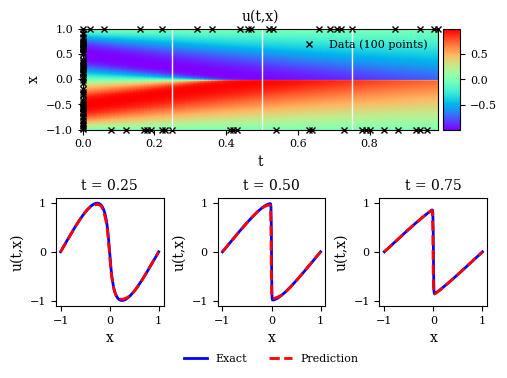

In [70]:
plot_inf_cont_results(X_star, u_pred_flat, X_u_train, u_train, Exact_u, X, T, x,
                      t)

# References

- Chen, F., Sondak, D., Protopapas, P., Mattheakis, M., Liu, S., Agarwal, D., & Giovanni, M. D. (2020). NeuroDiffEq: A Python package for solving differential equations with neural networks. Journal of Open Source Software, 5(46), 1931. https://doi.org/10.21105/joss.01931
- Chen, R. T. Q., Amos, B., & Nickel, M. (2021). Learning Neural Event Functions for Ordinary Differential Equations (arXiv:2011.03902). arXiv. http://arxiv.org/abs/2011.03902
- Chen, R. T. Q., Rubanova, Y., Bettencourt, J., & Duvenaud, D. (2019). Neural Ordinary Differential Equations (arXiv:1806.07366). arXiv. https://doi.org/10.48550/arXiv.1806.07366
- Cuomo, S., Di Cola, V. S., Giampaolo, F., Rozza, G., Raissi, M., & Piccialli, F. (2022). Scientific Machine Learning Through Physics–Informed Neural Networks: Where we are and What’s Next. Journal of Scientific Computing, 92(3), 88. https://doi.org/10.1007/s10915-022-01939-z
- Das, S., & Tesfamariam, S. (2022). State-of-the-Art Review of Design of Experiments for Physics-Informed Deep Learning (arXiv:2202.06416). arXiv.
- Dwivedi, V., Parashar, N., & Srinivasan, B. (2019). Distributed physics informed neural network for data-efficient solution to partial differential equations (arXiv:1907.08967). arXiv. http://arxiv.org/abs/1907.08967
- Kasim, M. F., Watson-Parris, D., Deaconu, L., Oliver, S., Hatfield, P., Froula, D. H., Gregori, G., Jarvis, M., Khatiwala, S., Korenaga, J., Topp-Mugglestone, J., Viezzer, E., & Vinko, S. M. (2022). Building high accuracy emulators for scientific simulations with deep neural architecture search. Machine Learning: Science and Technology, 3(1), 015013. https://doi.org/10.1088/2632-2153/ac3ffa
- Lawal, Z. K., Yassin, H., Lai, D. T. C., & Che Idris, A. (2022). Physics-Informed Neural Network (PINN) Evolution and Beyond: A Systematic Literature Review and Bibliometric Analysis. Big Data and Cognitive Computing, 6(4), 140. https://doi.org/10.3390/bdcc6040140
- Raissi, M., Perdikaris, P., & Karniadakis, G. (2021). CS598: Physics-Informed Neural Networks: A deep learning framework for solving forward and inverse problems involving nonlinear PDEs. https://arindam.cs.illinois.edu/courses/f21cs598/slides/pml11_598f21.pdf
- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017a). Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Diﬀerential Equations. https://arxiv.org/abs/1711.10561
- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017b). Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Diﬀerential Equations. https://arxiv.org/abs/1711.10566
- Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045
- Wang, S., Fan, K., Luo, N., Cao, Y., Wu, F., Zhang, C., Heller, K. A., & You, L. (2019). Massive computational acceleration by using neural networks to emulate mechanism-based biological models. Nature Communications, 10(1), Article 1. https://doi.org/10.1038/s41467-019-12342-y
- Xu, K., Zhu, W., & Darve, E. (2020). Distributed Machine Learning for Computational Engineering using MPI (arXiv:2011.01349). arXiv. http://arxiv.org/abs/2011.01349
